## Machine Learning Models

Using MPS device for GPU acceleration on Apple Silicon.
Connected to database quantummusic_csef. (fetch-only)
Database connection closed.
Total included records: 7947
[Quantum] Epoch 1/10: train_loss=4.5409, test_loss=4.1093
[Quantum] Epoch 2/10: train_loss=4.1225, test_loss=4.1058
[Quantum] Epoch 3/10: train_loss=4.1039, test_loss=4.1026
[Quantum] Epoch 4/10: train_loss=4.1017, test_loss=4.1052
[Quantum] Epoch 5/10: train_loss=4.0972, test_loss=4.0964
[Quantum] Epoch 6/10: train_loss=4.0950, test_loss=4.0935
[Quantum] Epoch 7/10: train_loss=4.0911, test_loss=4.0910
[Quantum] Epoch 8/10: train_loss=4.0874, test_loss=4.0917
[Quantum] Epoch 9/10: train_loss=4.0854, test_loss=4.0857
[Quantum] Epoch 10/10: train_loss=4.0843, test_loss=4.0842
[Quantum] Training complete or early stopped.


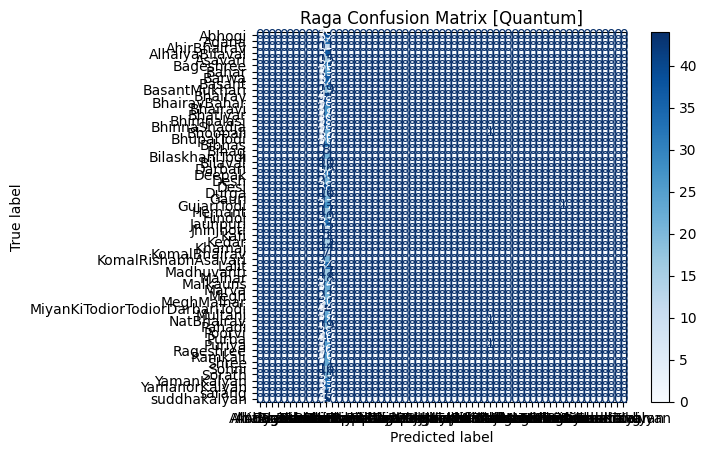

[Quantum] Raga Accuracy:  0.0239


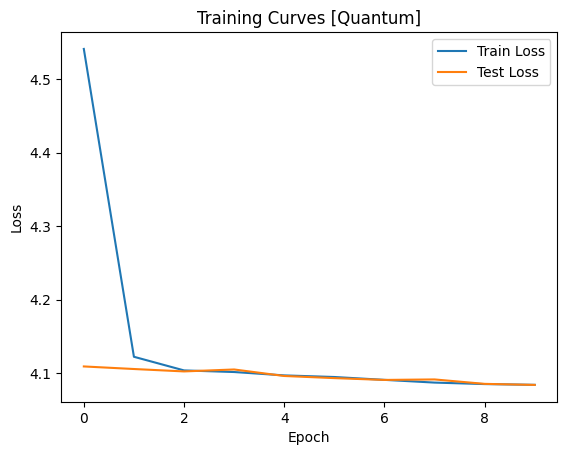

[Quantum] Model + metadata saved to: data/modeloutput/trained_model_raga_quantum.pt
Connected to database quantummusic_csef. (fetch-only)
Database connection closed.
Total included records: 7947
[NoQuantum] Epoch 1/10: train_loss=4.3790, test_loss=4.1074
[NoQuantum] Epoch 2/10: train_loss=4.1133, test_loss=4.1001
[NoQuantum] Epoch 3/10: train_loss=4.1050, test_loss=4.0928
[NoQuantum] Epoch 4/10: train_loss=4.0918, test_loss=4.0660
[NoQuantum] Epoch 5/10: train_loss=4.0789, test_loss=4.0562
[NoQuantum] Epoch 6/10: train_loss=4.0591, test_loss=4.0490
[NoQuantum] Epoch 7/10: train_loss=4.0519, test_loss=4.0550
[NoQuantum] Epoch 8/10: train_loss=4.0274, test_loss=4.0135
[NoQuantum] Epoch 9/10: train_loss=4.0257, test_loss=4.0080
[NoQuantum] Epoch 10/10: train_loss=4.0122, test_loss=4.0165
[NoQuantum] Training complete or early stopped.


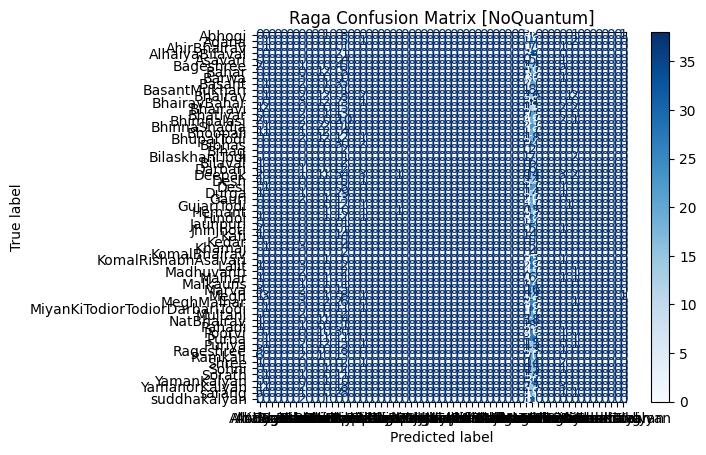

[NoQuantum] Raga Accuracy:  0.0346


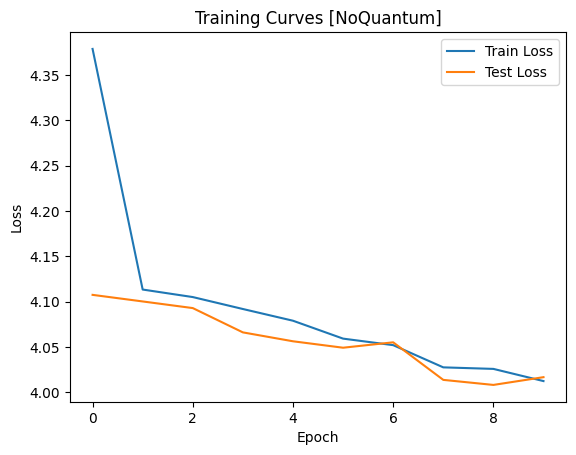

[NoQuantum] Model + metadata saved to: data/modeloutput/trained_model_raga_noquantum.pt
Connected to database quantummusic_csef. (fetch-only)
Database connection closed.
Total included records: 7947


/var/folders/98/ykbpmmjd0pdf8zgd8bc1hhmr0000gn/T/ipykernel_67587/2951491167.py:658: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_ckpt = torch.load(q_ckpt_path, map_locati


=== Raga-Only: Quantum vs. No-Quantum ===
Raga Accuracy (Quantum):     0.0252
Raga Accuracy (No-Quantum):  0.0327
Difference in Raga Accuracy = -0.76 % points


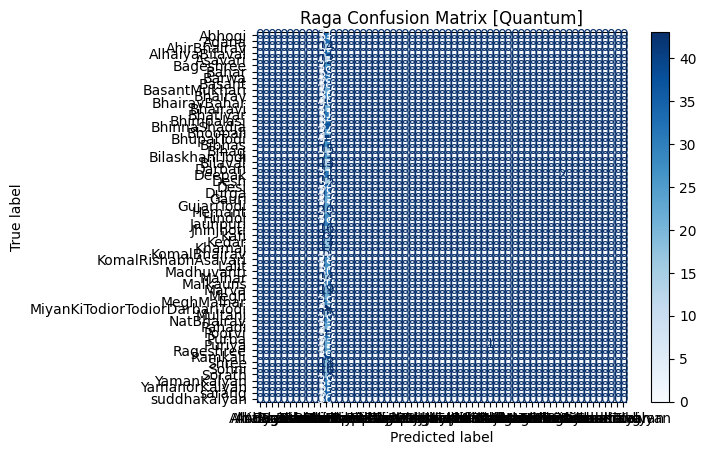

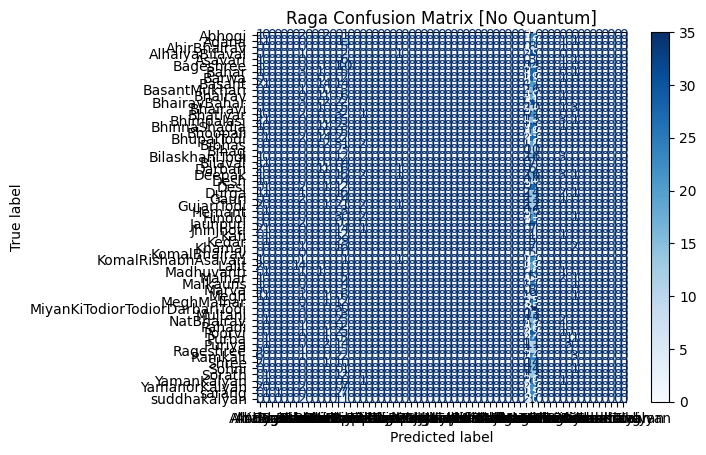

In [5]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

from transformers import ASTModel, ASTConfig
import torchvision.transforms as T
from PIL import Image

###############################################################################
# MPS DEVICE CHECK
###############################################################################
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using MPS device for GPU acceleration on Apple Silicon.")
else:
    DEVICE = torch.device("cpu")
    print("MPS not available. Falling back to CPU.")


###############################################################################
# HYPERPARAMETERS / GLOBAL SETTINGS
###############################################################################
HYPERPARAMS = {
    "OUTPUT_DIR": "data/trainingdataoutput",
    "DB_LIMIT": 100000,             # We'll read up to this many records (if needed)
    "BATCH_SIZE": 8,
    "EPOCHS": 10,                   # up to 10 or 20 epochs
    "LEARNING_RATE_MAIN": 5e-5,     # for AST layers (if we unfreeze them)
    "LEARNING_RATE_HEAD": 1e-4,     # for scalar/quantum/final layers
    "WEIGHT_DECAY": 1e-4,           # L2 regularization
    "DEVICE": DEVICE,
    "NUM_AST_LAYERS_UNFROZEN": 4,   # partial unfreezing
    "PATIENCE": 5,                  # early stopping patience
    "STOP_LIMIT": 5,                # must train at least this many epochs

    # AST model input shape for audio: (freq=128, time=1024) by default
    "AST_FREQ": 128,
    "AST_TIME": 1024
}


###############################################################################
# DATABASE FETCH LOGIC (FETCH ONLY)
###############################################################################
class QuantumMusicDBFetchOnly:
    """
    A minimal database utility class which fetches data from a Postgres table
    named 'audio_analysis'. This specialized version only supports reading.
    """
    def __init__(self, db_name="quantummusic_csef", host="localhost", user="postgres", password="postgres"):
        import psycopg2
        self.psycopg2 = psycopg2
        self.db_name = db_name
        self.host = host
        self.user = user
        self.password = password
        self.conn = None
        self.connect()

    def connect(self):
        try:
            import psycopg2
            self.conn = psycopg2.connect(
                dbname=self.db_name,
                host=self.host,
                user=self.user,
                password=self.password
            )
            print(f"Connected to database {self.db_name}. (fetch-only)")
        except Exception as e:
            print(f"Error connecting to database: {e}")

    def close(self):
        if self.conn:
            self.conn.close()
            print("Database connection closed.")

    def fetch_all_thaat_records(self):
        """
        Fetches rows from 'audio_analysis' where file_name contains 'thaat'.
        We rely on 'thaat' in the file_name to locate potential raga data as well.
        Returns list of (id, analysis_data).
        """
        with self.conn.cursor() as cur:
            query = """
                SELECT id, analysis_data
                FROM audio_analysis
                WHERE file_name ILIKE '%%thaat%%'
            """
            cur.execute(query)
            rows = cur.fetchall()
        return rows


###############################################################################
# HELPER FUNCTIONS
###############################################################################
def convert_counts_to_probs_feature(counts_dict, max_bits=10):
    """
    Convert a dictionary of quantum measurement counts into a probability
    distribution vector of length 2^max_bits.
    """
    total_counts = sum(counts_dict.values())
    if total_counts == 0:
        return np.zeros(2**max_bits, dtype=np.float32)

    feature_vec = np.zeros(2**max_bits, dtype=np.float32)
    for bitstring, c in counts_dict.items():
        if len(bitstring) > max_bits:
            truncated = bitstring[-max_bits:]
        else:
            truncated = bitstring.rjust(max_bits, '0')
        idx = int(truncated, 2)
        feature_vec[idx] += c / total_counts
    return feature_vec


def load_image_as_tensor(image_path: str):
    """
    Loads an image as a 1x128x128 tensor (grayscale). Returns None if not found.
    """
    transform_img = T.Compose([
        T.Resize((128, 128)),
        T.ToTensor()
    ])
    if not os.path.exists(image_path):
        return None
    with Image.open(image_path) as img:
        img = img.convert("L")
        return transform_img(img)  # => shape [1,128,128]


def parse_thaat_and_raga(file_name: str):
    """
    Parse 'thaat' and 'raga' from a file_name like: "Kalyan_thaat_Bhoopali_xyz.wav"
    Returns (thaat_str, raga_str). If parsing fails, returns (None, None).
    For raga-only classification, we only care about raga downstream.
    """
    base = file_name.replace(".wav", "")
    if "thaat_" not in base:
        return None, None

    parts = base.split("thaat_")
    if len(parts) != 2:
        return None, None

    thaat_str = parts[0].rstrip("_")
    right_part = parts[1]
    raga_parts = right_part.split("_", 1)
    raga_str = raga_parts[0]
    return thaat_str, raga_str


###############################################################################
# MAIN DATA FETCH + PARSE
###############################################################################
def fetch_training_data_raga_only(limit=None):
    """
    1) Fetch all DB records whose file_name contains 'thaat'.
    2) Parse out only the raga from the file_name.
    3) Build data arrays for:
        - mel spectrogram image
        - scalar features
        - quantum features
        - integer-encoded raga
    4) Return (data_dict, used_ids).
    """
    db = QuantumMusicDBFetchOnly()
    rows = db.fetch_all_thaat_records()
    db.close()

    if not rows:
        print("No 'thaat' data found in DB (for raga).")
        return None, []

    included_records = []
    for (record_id, analysis_data) in rows:
        fname = analysis_data["file_name"]
        _, raga = parse_thaat_and_raga(fname)
        if raga is not None:
            included_records.append((record_id, analysis_data))

    # Optional limit
    if limit is not None and len(included_records) > limit:
        included_records = included_records[:limit]

    if not included_records:
        print("No data left after filtering.")
        return None, []

    # Prepare arrays
    images_mel = []
    scalar_feats = []
    quantum_feats = []
    raga_labels = []
    used_ids = []

    all_ragas = set()

    print(f"Total included records: {len(included_records)}")

    for (record_id, analysis_data) in included_records:
        fname = analysis_data["file_name"]
        _, raga = parse_thaat_and_raga(fname)
        if raga is None:
            continue

        used_ids.append(record_id)
        all_ragas.add(raga)

        # Load mel-spectrogram
        base_no_ext = fname.replace(".wav", "")
        mel_path = os.path.join("data", "analysisoutput", f"{base_no_ext}_mel.png")
        mel_img = load_image_as_tensor(mel_path)
        if mel_img is None:
            # fallback
            mel_img = torch.zeros((1, 128, 128))

        images_mel.append(mel_img)

        # Extract scalar features
        summary_dict = analysis_data.get("summary", {})
        pitch_dev = summary_dict.get("pitch_deviation", {})
        tnr_dict  = summary_dict.get("tone_to_noise_ratio", {})
        praat_dict= summary_dict.get("praat", {})
        dynamics  = summary_dict.get("dynamics", {})

        avg_dev = pitch_dev.get("mean", 0.0)
        std_dev = pitch_dev.get("std", 0.0)
        avg_tnr = tnr_dict.get("mean", 0.0)
        avg_hnr = praat_dict.get("hnr_mean", 0.0)

        rms_db_stats = dynamics.get("rms_db", {})
        mean_rms_db  = rms_db_stats.get("mean", 0.0)
        lufs_stats   = dynamics.get("lufs", {})
        mean_lufs    = lufs_stats.get("mean", 0.0)

        time_matrices = analysis_data.get("time_matrices", {})
        time_matrix_small = time_matrices.get("time_matrix_small", [])

        jitter_vals = [x.get("jitter", 0.0) or 0.0 for x in time_matrix_small]
        shimmer_vals= [x.get("shimmer", 0.0) or 0.0 for x in time_matrix_small]
        vib_vals    = [x.get("vibrato_rate", 0.0) or 0.0 for x in time_matrix_small]
        f1_vals     = [x.get("formants", {}).get("F1", 0.0) or 0.0 for x in time_matrix_small]

        avg_jitter  = float(np.mean(jitter_vals))  if jitter_vals else 0.0
        avg_shimmer = float(np.mean(shimmer_vals)) if shimmer_vals else 0.0
        avg_vibrato = float(np.mean(vib_vals))     if vib_vals else 0.0
        avg_formant = float(np.mean(f1_vals))     if f1_vals else 0.0

        scalars = [
            avg_dev, std_dev,
            avg_hnr, avg_tnr,
            mean_rms_db, mean_lufs,
            avg_jitter, avg_shimmer,
            avg_vibrato, avg_formant
        ]
        scalar_feats.append(scalars)

        # Quantum features
        quantum_dict = analysis_data.get("quantum_analysis", {})
        angles = quantum_dict.get("scaled_angles", [])
        max_len = 10
        angle_arr = np.zeros(max_len, dtype=np.float32)
        for i in range(min(max_len, len(angles))):
            angle_arr[i] = angles[i]

        counts_d = quantum_dict.get("measurement_counts", {})
        dist_vec = convert_counts_to_probs_feature(counts_d, max_bits=10)
        combined_q = np.concatenate([angle_arr, dist_vec], axis=0)
        quantum_feats.append(combined_q)

        # We'll only store the raga label
        raga_labels.append(raga)

    # Build label map for ragas
    unique_ragas = sorted(list(all_ragas))
    raga_to_idx  = {r: i for i, r in enumerate(unique_ragas)}
    label_raga_idx  = [raga_to_idx[r] for r in raga_labels]

    # Final data structures
    images_mel    = torch.stack(images_mel)  # shape => (N, 1, 128, 128)
    scalar_feats  = np.array(scalar_feats, dtype=np.float32)
    quantum_feats = np.array(quantum_feats, dtype=np.float32)

    data_dict = {
        "images_mel": images_mel,
        "scalar_feats": scalar_feats,
        "quantum_feats": quantum_feats,
        "label_raga_idx": np.array(label_raga_idx, dtype=np.int64),
        "raga_to_idx": raga_to_idx,
        "unique_ragas": unique_ragas
    }

    return data_dict, used_ids


###############################################################################
# DATASET & MODEL
###############################################################################
class RagaDataset(Dataset):
    """
    Each sample has:
       1) mel_imgs
       2) scalar features
       3) quantum features
       4) raga label (single-label classification)
    """
    def __init__(self, data_dict):
        self.mel_imgs   = data_dict["images_mel"]
        self.scalars    = data_dict["scalar_feats"]
        self.quants     = data_dict["quantum_feats"]
        self.raga_lbl   = data_dict["label_raga_idx"]

    def __len__(self):
        return len(self.raga_lbl)

    def __getitem__(self, idx):
        scal  = torch.tensor(self.scalars[idx], dtype=torch.float32)
        quan  = torch.tensor(self.quants[idx], dtype=torch.float32)
        r_lbl = torch.tensor(self.raga_lbl[idx], dtype=torch.long)
        return (
            self.mel_imgs[idx],
            scal,
            quan,
            r_lbl
        )


class HybridASTModelRaga(nn.Module):
    """
    A single-head AST model for Raga classification.
    Optionally fuses scalar + quantum features with the AST embedding,
    then outputs raga logits.
    """
    def __init__(self, num_ragas, scalar_dim=10, quantum_dim=(10 + 2**10), 
                 num_unfrozen_layers=0, use_quantum=True):
        super().__init__()
        # Load AST model
        self.config = ASTConfig.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
        self.ast_model = ASTModel.from_pretrained(
            "MIT/ast-finetuned-audioset-10-10-0.4593",
            config=self.config
        )

        # Freeze the AST
        for param in self.ast_model.parameters():
            param.requires_grad = False

        # Unfreeze the last N encoder layers if requested
        if num_unfrozen_layers > 0:
            total_layers = 12
            start_layer = max(0, total_layers - num_unfrozen_layers)
            for layer_idx in range(start_layer, total_layers):
                for param in self.ast_model.encoder.layer[layer_idx].parameters():
                    param.requires_grad = True

        # MLP for scalar features
        self.scalar_fc = nn.Sequential(
            nn.Linear(scalar_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        # MLP for quantum features
        self.use_quantum = use_quantum
        if use_quantum:
            self.quantum_fc = nn.Sequential(
                nn.Linear(quantum_dim, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
            )

        # AST base output is 768 dims
        if self.use_quantum:
            combined_dim = 768 + 64 + 64
        else:
            combined_dim = 768 + 64

        # Single classification head for raga
        self.raga_head = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_ragas)
        )

    def forward(self, mel_img, scal_in, quan_in=None):
        # Resize mel_img to match AST input shape
        B, C, H, W = mel_img.shape
        freq = HYPERPARAMS["AST_FREQ"]
        time = HYPERPARAMS["AST_TIME"]

        mel_resized = F.interpolate(
            mel_img, size=(freq, time),
            mode='bilinear', align_corners=False
        )
        # AST wants shape (B, freq, time)
        mel_for_ast = mel_resized.squeeze(1)

        outputs = self.ast_model(
            input_values=mel_for_ast,
            output_hidden_states=True
        )
        hidden = outputs.last_hidden_state  # (B, seq_len, 768)
        ast_embedding = hidden[:, 0, :]     # [CLS] => (B,768)

        emb_scal = self.scalar_fc(scal_in)  # (B,64)

        if self.use_quantum and quan_in is not None:
            emb_quan = self.quantum_fc(quan_in)  # (B,64)
            fused = torch.cat([ast_embedding, emb_scal, emb_quan], dim=1)
        else:
            fused = torch.cat([ast_embedding, emb_scal], dim=1)

        logits_raga = self.raga_head(fused)   # (B, num_ragas)
        return logits_raga


###############################################################################
# TRAINING FUNCTION
###############################################################################
def train_raga_model(use_quantum=True):
    """
    Main training function for Raga classification.
    If `use_quantum=True`, includes quantum features in the fusion,
    otherwise only AST + scalar features.
    """
    # Fetch data
    data_dict, used_ids = fetch_training_data_raga_only(limit=HYPERPARAMS["DB_LIMIT"])
    if data_dict is None:
        print("No data to train.")
        return None, None

    # Create dataset
    dataset_full = RagaDataset(data_dict)
    n_samples = len(dataset_full)
    test_size = int(0.2 * n_samples)
    train_size = n_samples - test_size
    train_ds, test_ds = torch.utils.data.random_split(dataset_full, [train_size, test_size])
    train_dl = DataLoader(train_ds, batch_size=HYPERPARAMS["BATCH_SIZE"], shuffle=True)
    test_dl  = DataLoader(test_ds, batch_size=HYPERPARAMS["BATCH_SIZE"], shuffle=False)

    scalar_feats = data_dict["scalar_feats"]
    quantum_feats= data_dict["quantum_feats"]
    num_ragas    = len(data_dict["raga_to_idx"])

    # Build model
    model = HybridASTModelRaga(
        num_ragas=num_ragas,
        scalar_dim=scalar_feats.shape[1],
        quantum_dim=quantum_feats.shape[1],
        num_unfrozen_layers=HYPERPARAMS["NUM_AST_LAYERS_UNFROZEN"],
        use_quantum=use_quantum
    ).to(HYPERPARAMS["DEVICE"])

    optimizer = optim.Adam(
        model.parameters(),
        lr=HYPERPARAMS["LEARNING_RATE_HEAD"],
        weight_decay=HYPERPARAMS["WEIGHT_DECAY"]
    )
    crit_ce = nn.CrossEntropyLoss()

    EPOCHS = HYPERPARAMS["EPOCHS"]
    train_losses = []
    test_losses = []
    best_test_loss = float("inf")
    best_model_state = None
    patience = HYPERPARAMS["PATIENCE"]
    epochs_no_improve = 0
    stop_limit = HYPERPARAMS["STOP_LIMIT"]

    for epoch in range(EPOCHS):
        # TRAIN
        model.train()
        total_train_loss = 0.0

        for batch in train_dl:
            mel_img, scal, quan, r_lbl = batch
            mel_img = mel_img.to(HYPERPARAMS["DEVICE"])
            scal    = scal.to(HYPERPARAMS["DEVICE"])
            quan    = quan.to(HYPERPARAMS["DEVICE"])
            r_lbl   = r_lbl.to(HYPERPARAMS["DEVICE"])

            optimizer.zero_grad()
            if use_quantum:
                logits_raga = model(mel_img, scal, quan)
            else:
                logits_raga = model(mel_img, scal, None)

            loss_raga  = crit_ce(logits_raga, r_lbl)
            loss_raga.backward()
            optimizer.step()
            total_train_loss += loss_raga.item()

        avg_train_loss = total_train_loss / len(train_dl)
        train_losses.append(avg_train_loss)

        # EVAL
        model.eval()
        total_test_loss = 0.0
        with torch.no_grad():
            for batch in test_dl:
                mel_img, scal, quan, r_lbl = batch
                mel_img = mel_img.to(HYPERPARAMS["DEVICE"])
                scal    = scal.to(HYPERPARAMS["DEVICE"])
                quan    = quan.to(HYPERPARAMS["DEVICE"])
                r_lbl   = r_lbl.to(HYPERPARAMS["DEVICE"])

                if use_quantum:
                    logits_raga = model(mel_img, scal, quan)
                else:
                    logits_raga = model(mel_img, scal, None)

                loss_raga = crit_ce(logits_raga, r_lbl)
                total_test_loss += loss_raga.item()

        avg_test_loss = total_test_loss / len(test_dl)
        test_losses.append(avg_test_loss)

        prefix = "[Quantum]" if use_quantum else "[NoQuantum]"
        print(f"{prefix} Epoch {epoch+1}/{EPOCHS}: train_loss={avg_train_loss:.4f}, test_loss={avg_test_loss:.4f}")

        # Early Stopping
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if (epoch + 1) >= stop_limit and epochs_no_improve >= patience:
                print(f"{prefix} No improvement for {patience} epochs after epoch {stop_limit}. Stopping.")
                break

    print(f"{prefix} Training complete or early stopped.")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation: confusion matrix + accuracy
    all_raga_preds, all_raga_truth = [], []

    model.eval()
    with torch.no_grad():
        for batch in test_dl:
            mel_img, scal, quan, r_lbl = batch
            mel_img = mel_img.to(HYPERPARAMS["DEVICE"])
            scal    = scal.to(HYPERPARAMS["DEVICE"])
            quan    = quan.to(HYPERPARAMS["DEVICE"])
            r_lbl   = r_lbl.to(HYPERPARAMS["DEVICE"])

            if use_quantum:
                logits_raga = model(mel_img, scal, quan)
            else:
                logits_raga = model(mel_img, scal, None)

            pred_raga  = logits_raga.argmax(dim=1).cpu().numpy()
            all_raga_preds.extend(pred_raga)
            all_raga_truth.extend(r_lbl.cpu().numpy())

    # Compute confusion matrix for raga
    cm_raga = confusion_matrix(all_raga_truth, all_raga_preds)
    used_raga_indices = sorted(set(all_raga_truth) | set(all_raga_preds))
    idx_to_raga = {v: k for k, v in data_dict["raga_to_idx"].items()}
    used_raga_labels = [idx_to_raga[i] for i in used_raga_indices]

    disp_raga = ConfusionMatrixDisplay(cm_raga, display_labels=used_raga_labels)
    disp_raga.plot(cmap=plt.cm.Blues)
    plt.title(f"Raga Confusion Matrix {prefix}")
    plt.show()

    # Compute accuracy
    raga_acc  = accuracy_score(all_raga_truth, all_raga_preds)
    print(f"{prefix} Raga Accuracy:  {raga_acc:.4f}")

    # Plot training curves
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Curves {prefix}")
    plt.legend()
    plt.show()

    # Save model
    os.makedirs("data/modeloutput", exist_ok=True)
    if use_quantum:
        checkpoint_path = os.path.join("data", "modeloutput", "trained_model_raga_quantum.pt")
    else:
        checkpoint_path = os.path.join("data", "modeloutput", "trained_model_raga_noquantum.pt")

    checkpoint_dict = {
        "model_state": model.state_dict(),
        "raga_to_idx": data_dict["raga_to_idx"],
        "scalar_dim": scalar_feats.shape[1],
        "quantum_dim": quantum_feats.shape[1],
        "num_ragas": num_ragas,
        "used_ids": used_ids
    }
    torch.save(checkpoint_dict, checkpoint_path)
    print(f"{prefix} Model + metadata saved to: {checkpoint_path}")

    return model, data_dict


###############################################################################
# COMPARISON FUNCTION: QUANTUM VS. NO-QUANTUM (RAGA-ONLY)
###############################################################################
def compare_thaat_raga_models():
    """
    Compare two raga-only models:
      1) The model with quantum features (trained_model_raga_quantum.pt)
      2) The model without quantum features (trained_model_raga_noquantum.pt)

    1) Fetch the same dataset (using fetch_training_data_raga_only).
    2) Build a test set split (20%).
    3) Load both models from their checkpoints.
    4) Evaluate both on the same test set.
    5) Print confusion matrix and accuracy for Raga.
    """
    data_dict, used_ids = fetch_training_data_raga_only(limit=HYPERPARAMS["DB_LIMIT"])
    if data_dict is None:
        print("[Compare] No raga data for comparison.")
        return

    # Create the same dataset/split as train_raga_model did:
    dataset_full = RagaDataset(data_dict)
    n_samples = len(dataset_full)
    test_size = int(0.2 * n_samples)
    train_size = n_samples - test_size
    # We only want to evaluate on the test set, not retrain
    _, test_ds = torch.utils.data.random_split(dataset_full, [train_size, test_size])
    test_dl = DataLoader(test_ds, batch_size=HYPERPARAMS["BATCH_SIZE"], shuffle=False)

    # Paths to the two saved checkpoints
    q_ckpt_path = "data/modeloutput/trained_model_raga_quantum.pt"
    nq_ckpt_path = "data/modeloutput/trained_model_raga_noquantum.pt"

    # Load quantum model checkpoint
    if not os.path.exists(q_ckpt_path):
        print(f"[Compare] Quantum model not found at {q_ckpt_path}")
        return
    q_ckpt = torch.load(q_ckpt_path, map_location=HYPERPARAMS["DEVICE"])

    q_model = HybridASTModelRaga(
        num_ragas=q_ckpt["num_ragas"],
        scalar_dim=q_ckpt["scalar_dim"],
        quantum_dim=q_ckpt["quantum_dim"],
        num_unfrozen_layers=HYPERPARAMS["NUM_AST_LAYERS_UNFROZEN"],
        use_quantum=True
    )
    q_model.load_state_dict(q_ckpt["model_state"])
    q_model.to(HYPERPARAMS["DEVICE"])
    q_model.eval()

    # Load no-quantum model checkpoint
    if not os.path.exists(nq_ckpt_path):
        print(f"[Compare] No-Quantum model not found at {nq_ckpt_path}")
        return
    nq_ckpt = torch.load(nq_ckpt_path, map_location=HYPERPARAMS["DEVICE"])

    nq_model = HybridASTModelRaga(
        num_ragas=nq_ckpt["num_ragas"],
        scalar_dim=nq_ckpt["scalar_dim"],
        quantum_dim=nq_ckpt["quantum_dim"],
        num_unfrozen_layers=HYPERPARAMS["NUM_AST_LAYERS_UNFROZEN"],
        use_quantum=False
    )
    nq_model.load_state_dict(nq_ckpt["model_state"])
    nq_model.to(HYPERPARAMS["DEVICE"])
    nq_model.eval()

    # Evaluate both
    all_true_ragas = []
    preds_raga_q = []
    preds_raga_nq = []

    with torch.no_grad():
        for mel_img, scal, quan, r_lbl in test_dl:
            mel_img = mel_img.to(HYPERPARAMS["DEVICE"])
            scal    = scal.to(HYPERPARAMS["DEVICE"])
            quan    = quan.to(HYPERPARAMS["DEVICE"])
            r_lbl   = r_lbl.to(HYPERPARAMS["DEVICE"])

            # Quantum
            logits_raga_q = q_model(mel_img, scal, quan)
            pred_r_q = logits_raga_q.argmax(dim=1).cpu().numpy()

            # NoQuantum
            logits_raga_nq = nq_model(mel_img, scal, None)
            pred_r_nq = logits_raga_nq.argmax(dim=1).cpu().numpy()

            all_true_ragas.extend(r_lbl.cpu().numpy())
            preds_raga_q.extend(pred_r_q)
            preds_raga_nq.extend(pred_r_nq)

    # Accuracy
    raga_acc_q  = accuracy_score(all_true_ragas, preds_raga_q)
    raga_acc_nq = accuracy_score(all_true_ragas, preds_raga_nq)

    print("\n=== Raga-Only: Quantum vs. No-Quantum ===")
    print(f"Raga Accuracy (Quantum):     {raga_acc_q:.4f}")
    print(f"Raga Accuracy (No-Quantum):  {raga_acc_nq:.4f}")

    d_raga  = (raga_acc_q - raga_acc_nq) * 100
    print(f"Difference in Raga Accuracy = {d_raga:.2f} % points")

    # Confusion matrices for each model
    # Quantum
    cm_raga_q = confusion_matrix(all_true_ragas, preds_raga_q)
    idx_to_raga = {v: k for k, v in data_dict["raga_to_idx"].items()}
    used_indices_q = sorted(set(all_true_ragas) | set(preds_raga_q))
    used_raga_labels_q = [idx_to_raga[i] for i in used_indices_q]

    disp_raga_q = ConfusionMatrixDisplay(cm_raga_q, display_labels=used_raga_labels_q)
    disp_raga_q.plot(cmap=plt.cm.Blues)
    plt.title("Raga Confusion Matrix [Quantum]")
    plt.show()

    # No Quantum
    cm_raga_nq = confusion_matrix(all_true_ragas, preds_raga_nq)
    used_indices_nq = sorted(set(all_true_ragas) | set(preds_raga_nq))
    used_raga_labels_nq = [idx_to_raga[i] for i in used_indices_nq]

    disp_raga_nq = ConfusionMatrixDisplay(cm_raga_nq, display_labels=used_raga_labels_nq)
    disp_raga_nq.plot(cmap=plt.cm.Blues)
    plt.title("Raga Confusion Matrix [No Quantum]")
    plt.show()


###############################################################################
# EXAMPLE MAIN
###############################################################################
if __name__ == "__main__":
    # 1) Train with quantum features
    model_q, data_q = train_raga_model(use_quantum=True)

    # 2) Train without quantum features
    model_nq, data_nq = train_raga_model(use_quantum=False)

    # 3) Compare
    compare_thaat_raga_models()